#### 直方图投影

In [1]:
import sys
sys.path.append("../utils")
from imgload import *
import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

#### 1. 饱和度调整

In [2]:

def hls_adj(ori_img):
    image = ori_img.copy()
    fImg = image.astype(np.float32)
    fImg = fImg / 255.0
    # 颜色空间转换 BGR转为HLS
    hlsImg = cv2.cvtColor(fImg, cv2.COLOR_BGR2HLS)

    l = 10
    s = 360
    MAX_VALUE = 100
    hlsCopy = np.copy(hlsImg)

    hlsCopy[:, :, 1] = (1.0 + l / float(MAX_VALUE)) * hlsCopy[:, :, 1]
    hlsCopy[:, :, 1][hlsCopy[:, :, 1] > 1] = 1
    hlsCopy[:, :, 2] = (1.0 + s / float(MAX_VALUE)) * hlsCopy[:, :, 2]

    hlsCopy[:, :, 2][hlsCopy[:, :, 2] > 1] = 1
    lsImg = cv2.cvtColor(hlsCopy, cv2.COLOR_HLS2BGR)
    lsImg = lsImg * 255.0

    lsImg = lsImg.astype(np.uint8)
    
    return lsImg


url_path= 'https://uploadfile.huiyi8.com/2015/1120/20151120035805807.jpg'

ori_img = url2img(url_path)

# hls_img = hls_adj(ori_img)
# cv2pil(hls_img)



#### 颜色直方图

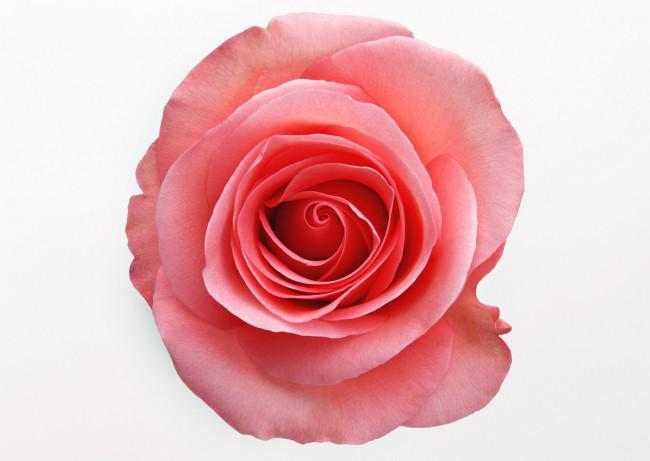

In [3]:
cv2pil(ori_img)

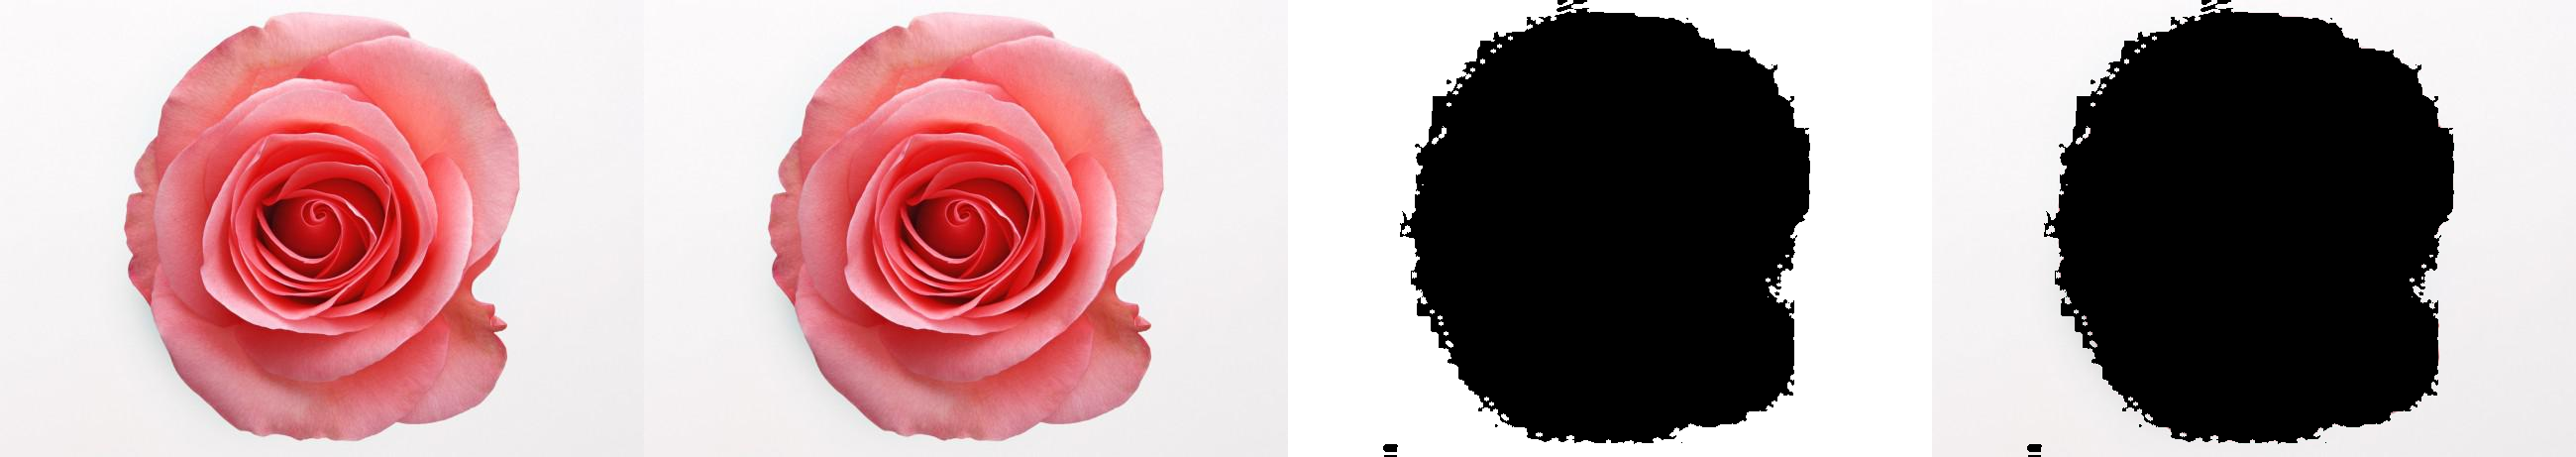

In [4]:
target_url = "https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic.51yuansu.com%2Fpic3%2Fcover%2F01%2F86%2F87%2F598182d112acd_610.jpg&refer=http%3A%2F%2Fpic.51yuansu.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=auto?sec=1656116445&t=f1f16776b286f1ee6eae99c45b5a5e3f"
target_img = url2img(target_url)
h, w, _ = ori_img.shape
target_img = cv2.resize(ori_img, (w, h))
hsv = cv2.cvtColor(ori_img,cv2.COLOR_BGR2HSV)
hsvt = cv2.cvtColor(target_img,cv2.COLOR_BGR2HSV)

roihist = cv2.calcHist([hsv],[0, 1], None, [180, 256], [0, 180, 0, 256] )

# roihist.max(), roihist.min() ### 需要归一化处理

cv2.normalize(roihist,roihist,0,255,cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsvt],[0,1],roihist,[0,180,0,256],1)

disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
dst=cv2.filter2D(dst,-1,disc)

# cv2pil(dst)
ret,thresh = cv2.threshold(dst,50,255,0)
thresh = cv2.merge((thresh,thresh,thresh)) ### # 别忘了是三通道图像，因此这里使用 merge 变成 3 通道
res = cv2.bitwise_and(target_img,thresh) ## # 按位操作
res = np.hstack((ori_img, target_img,thresh,res))
cv2pil(res)



#### 傅里叶变化

###

In [5]:
f = np.fft.fft2(ori_img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))


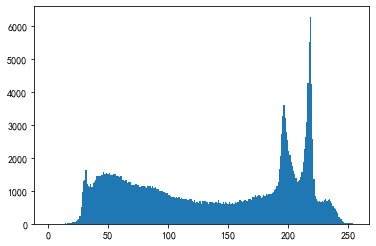

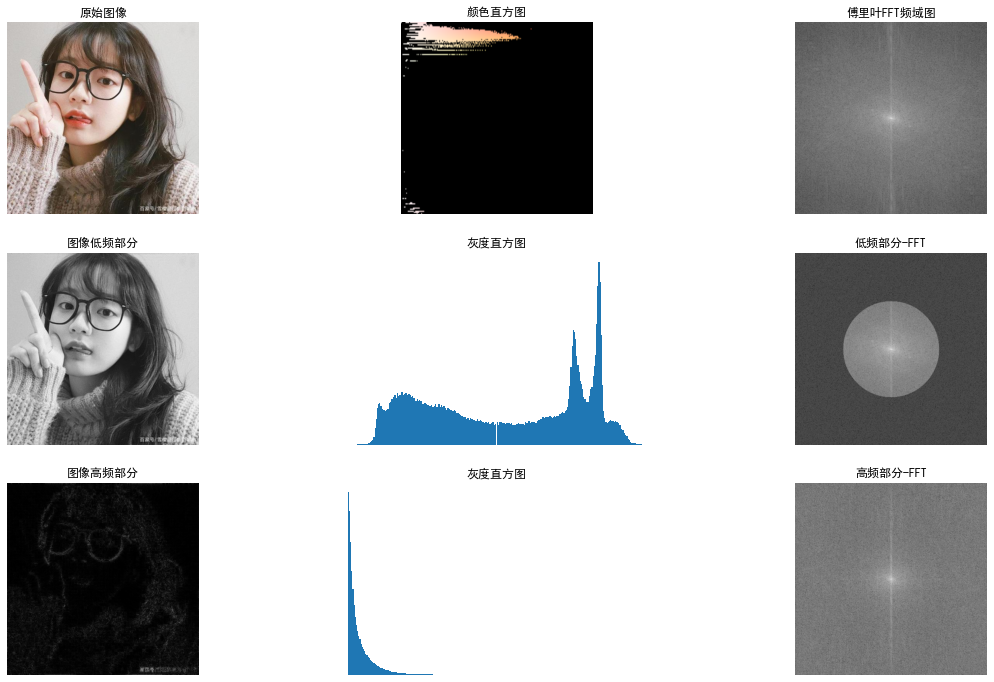

In [6]:
def filter_high_f(img, fshift, radius_ratio):
    """
    过滤掉除了中⼼区域外的⾼频信息
    """
    # 1, ⽣成圆形过滤器, 圆内值1, 其他部分为0的过滤器, 过滤
    template = np.zeros(fshift.shape, np.uint8)
    crow, ccol = int(fshift.shape[0] / 2), int(fshift.shape[1] / 2)  # 圆⼼
    radius = int(radius_ratio * img.shape[0] / 2)
    if len(img.shape) == 3:
        cv2.circle(template, (crow, ccol), radius, (1, 1, 1), -1)
    else:
        cv2.circle(template, (crow, ccol), radius, 1, -1)
    # 2, 过滤掉除了中⼼区域外的⾼频信息
    return template * fshift


def filter_low_f(img, fshift, radius_ratio):
    """
    去除中⼼区域低频信息
    """
    # 1 ⽣成圆形过滤器, 圆内值0, 其他部分为1的过滤器, 过滤
    filter_img = np.ones(fshift.shape, np.uint8)
    crow, col = int(fshift.shape[0] / 2), int(fshift.shape[1] / 2)
    radius = int(radius_ratio * img.shape[0] / 2)
    if len(img.shape) == 3:
        cv2.circle(filter_img, (crow, col), radius, (0, 0, 0), -1)
    else:
        cv2.circle(filter_img, (crow, col), radius, 0, -1)
    # 2 过滤中⼼低频部分的信息
    return filter_img * fshift


def ifft(fshift):
    """
    傅⾥叶逆变换
    """
    ishift = np.fft.ifftshift(fshift)  # 把低频部分sift回左上⾓
    iimg = np.fft.ifftn(ishift)  # 出来的是复数，⽆法显⽰
    iimg = np.abs(iimg)  # 返回复数的模
    return iimg

def fft(img):
    """
    傅⾥叶变换
    """
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    return magnitude_spectrum

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
def get_low_high_f(img, radius_ratio):
    """
    获取低频和⾼频部分图像
    """
    # 傅⾥叶变换
    # np.fft.fftn
    f = np.fft.fftn(img)  # Compute the N-dimensional discrete Fourier Transform. 零频率分量位于频谱图像的左上⾓
    fshift = np.fft.fftshift(f)  # 零频率分量会被移到频域图像的中⼼位置，即低频
    # 获取低频和⾼频部分
    hight_parts_fshift = filter_low_f(img, fshift.copy(), radius_ratio=radius_ratio)  # 过滤掉中⼼低频
    low_parts_fshift = filter_high_f(img, fshift.copy(), radius_ratio=radius_ratio)
    low_parts_img = ifft(low_parts_fshift)  # 先sift回来，再反傅⾥叶变换
    high_parts_img = ifft(hight_parts_fshift)
    # 显⽰原始图像和⾼通滤波处理图像
    img_new_low = (low_parts_img - np.amin(low_parts_img)) / (np.amax(low_parts_img) - np.amin(low_parts_img) + 0.00001)
    img_new_high = (high_parts_img - np.amin(high_parts_img) + 0.00001) / (np.amax(high_parts_img) - np.amin(high_parts_img) + 0.00001)
    # uint8
    img_new_low = np.array(img_new_low*255, np.uint8)
    img_new_high = np.array(img_new_high * 255, np.uint8)
    return img_new_low, img_new_high



def color_hist(cv2_img):
    """ 颜色直方图 """
    hist_scale = 10
    hh, ww, _ = cv2_img.shape
    
    hsv_map = np.zeros((180, 256, 3), np.uint8)
    h, s = np.indices(hsv_map.shape[:2])
    hsv_map[:,:,0] = h
    hsv_map[:,:,1] = s
    hsv_map[:,:,2] = 255
    hsv_map = cv2.cvtColor(hsv_map, cv2.COLOR_HSV2BGR)

    small = cv2.pyrDown(cv2_img)
    hsv = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2HSV)
    dark = hsv[:,:,2] < 32
    hsv[dark] = 0
    
    h = cv2.calcHist( [hsv], [0, 1], None, [180, 256], [0, 180, 0, 256] )
    h = np.clip(h*0.005*hist_scale, 0, 1)
    imghist = hsv_map*h[:,:,np.newaxis].astype("uint8")
   
    imghist = cv2.resize(imghist, (ww, hh))
    
    del hsv_map, h,s
    
    return imghist





url_path= 'https://uploadfile.huiyi8.com/2015/1120/20151120035805807.jpg'
url_path = 'https://img1.baidu.com/it/u=2224139339,4032510121&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=500'
# url_path = 'https://img0.baidu.com/it/u=871579864,2808502807&fm=253&fmt=auto&app=138&f=JPEG?w=889&h=500'

ori_img = url2img(url_path)

radius_ratio = 0.5 
img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)


plt.hist(img.ravel(), 255)

img_hist = color_hist(ori_img)
low_freq_part_img, high_freq_part_img = get_low_high_f(img, radius_ratio=radius_ratio)  # multi channel or single

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1), plt.imshow(ori_img[:,:,::-1]), plt.title('原始图像'), plt.axis('off')
plt.subplot(3,3,2), plt.imshow(img_hist[:,:,::-1]), plt.title('颜色直方图'), plt.axis('off')
plt.subplot(3,3,3), plt.imshow(fft(img), 'gray'), plt.title('傅里叶FFT频域图'), plt.axis('off')

plt.subplot(3,3,4), plt.imshow(low_freq_part_img, 'gray'), plt.title('图像低频部分'), plt.axis('off')
plt.subplot(3,3,5), plt.hist(low_freq_part_img.ravel(), 256), plt.title('灰度直方图'), plt.axis('off')
plt.subplot(3,3,6), plt.imshow(fft(low_freq_part_img), 'gray'), plt.title('低频部分-FFT'), plt.axis('off')


plt.subplot(3,3,7), plt.imshow(high_freq_part_img, 'gray'), plt.title('图像高频部分'), plt.axis('off')
plt.subplot(3,3,8), plt.hist(high_freq_part_img.ravel(), 256), plt.title('灰度直方图'), plt.axis('off')
plt.subplot(3,3,9), plt.imshow(fft(high_freq_part_img), 'gray'), plt.title('高频部分-FFT'), plt.axis('off')
plt.show()


(<matplotlib.axes._subplots.AxesSubplot at 0x25d78ffcac8>,
 Text(0.5, 1.0, '图像增强'),
 (-0.5, 649.5, 460.5, -0.5))

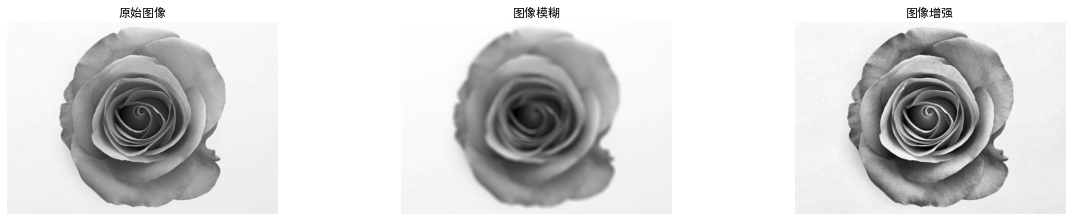

In [7]:
url_path= 'https://uploadfile.huiyi8.com/2015/1120/20151120035805807.jpg'
# url_path = 'https://img1.baidu.com/it/u=2224139339,4032510121&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=500'
# url_path = 'https://img0.baidu.com/it/u=871579864,2808502807&fm=253&fmt=auto&app=138&f=JPEG?w=889&h=500'

ori_img = url2img(url_path)

gray = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)

blur_img = cv2.blur(gray, (11, 11))
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray)

# res_img = np.hstack((gray, blur_img, cl1))
# cv2pil(res_img)

plt.figure(figsize=(20, 12))
plt.subplot(3,3,1), plt.imshow(gray, 'gray'), plt.title('原始图像'), plt.axis('off')
plt.subplot(3,3,2), plt.imshow(blur_img, 'gray'), plt.title('图像模糊'), plt.axis('off')
plt.subplot(3,3,3), plt.imshow(cl1, 'gray'), plt.title('图像增强'), plt.axis('off')



#### 图像转为字符串显示

(<matplotlib.axes._subplots.AxesSubplot at 0x25d78c8bcf8>,
 Text(0.5, 1.0, '你的女孩'),
 (-0.5, 499.5, 499.5, -0.5))

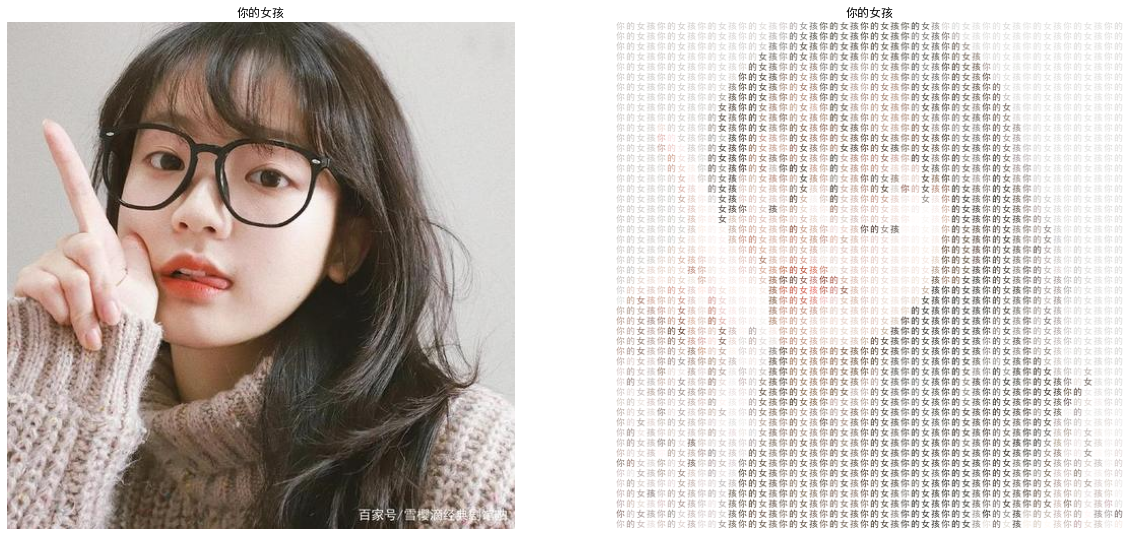

In [47]:
import cv2
from PIL import Image,ImageDraw,ImageFont
import os
  
  
# ascii_char = list("$@B%8&WM#*oahkbdpqwmZO0QLCJUYXzcvunxrjft/\|()1{}[]?-_+~<>i!lI;:,\"^`'. ") 
ascii_char = list(" -/1") 
  
# 将灰度值转为字符 
def get_char(gray_number): 
    length = len(ascii_char) 
    unit = (256.0 + 1)/length 
    return ascii_char[int(gray_number/unit)] 
  
def img2str(cv2_img, text = '加油', n = 10, to_cv2=True):
    h, w, _ = cv2_img.shape
    cv2_img = cv2_img[:, :, (2, 1, 0)] 
    pil_img_draw = Image.new("RGB", [h, w], color="white")
    draeobj = ImageDraw.Draw(pil_img_draw)
    font = ImageFont.truetype('./font/simhei.ttf',size=n-1)
    for i in range(0,h,n):
        for j in range(0,w,n):
            draeobj.ink = cv2_img[i][j][0] + cv2_img[i][j][1]*256 + cv2_img[i][j][2]*256*256
            ttext = text[int(j/n)%len(text)]
            draeobj.text([j,i], ttext, font=font)
    if to_cv2:
        return cv2.cvtColor(np.asarray(pil_img_draw),cv2.COLOR_RGB2BGR)
    
    return pil_img_draw




url_path = 'https://img1.baidu.com/it/u=2224139339,4032510121&fm=253&fmt=auto&app=138&f=JPEG?w=500&h=500'
ori_img = url2img(url_path)
str_img = img2str(ori_img, text="你的女孩", n=10, to_cv2=True)
plt.figure(figsize=(20, 12))
plt.subplot(1,2,1), plt.imshow(ori_img[:,:,::-1]), plt.title('你的女孩'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(str_img[:,:,::-1]), plt.title('你的女孩'), plt.axis('off')